# About The Project

Wayback Google Analytics is a lightweight tool that gathers current and historic Google analytics data (UA, GA and GTM codes) from a collection of website urls.

Read Bellingcat's article about using this tool to uncover disinformation networks online [here](https://www.bellingcat.com/resources/2024/01/09/using-the-wayback-machine-and-google-analytics-to-uncover-disinformation-networks/).

# Why do I need GA codes?

Google Analytics codes are a useful data point when examining relationships between websites. If two seemingly disparate websites share the same UA, GA or GTM code then there is a good chance that they are managed by the same individual or group.

This useful breadcrumb has been used by researchers and journalists in OSINT investigations regularly over the last decade, but a recent change in how Google handles its analytics codes threatens to limit its effectiveness. Google began phasing out UA codes as part of its Google Analytics 4 upgrade in July 2023, making it significantly more challenging to use this breadcrumb during investigations.

# How does this notebook help me?

Luckily, the Internet Archive's [Wayback Machine](https://archive.org/web/) contains useful snapshots of websites containing their historic GA IDs. While you could feasibly check each snapshot manually, this tool automates that process with the Wayback Machines CDX API to simplify and speed up the process. Enter a list of urls and a time frame (along with extra, optional parameters) to collect current and historic GA, UA and GTM codes.

# Getting started

Fill in the parameters in the form below and click the 'run' buttons. If all goes well, the notebook displays a diagram showing which UA/GA codes that were used by the websites.

In [1]:
# @markdown #### Download some more code from Github:
![ -d wga ] || git clone https://github.com/CoRoe/wga

['/content/wga', '/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython']
Entered main 2014-05-29
Failed to reach cloudflare.net cloudflare.net
Retrieving current codes for:  cloudflare.net
Retrieving archived codes for:  cloudflare.net
CDX url:  http://web.archive.org/cdx/search/cdx?url=cloudflare.net&matchType=domain&filter=statuscode:200&fl=timestamp&output=JSON&collapse=timestamp:8&limit=34&from=20140529000000&to=20140630000000
Timestamps from CDX api:  ['20140621130434', '20140624085018']
Retrieving codes from url:  https://web.archive.org/web/20140621130434/cloudflare.net
Finish gathering codes for:  https://web.archive.org/web/20140621130434/cloudflare.net
Retrieving codes from url:  https://web.archive.org/web/20140624085018/cloudflare.net
Finish gathering codes for:

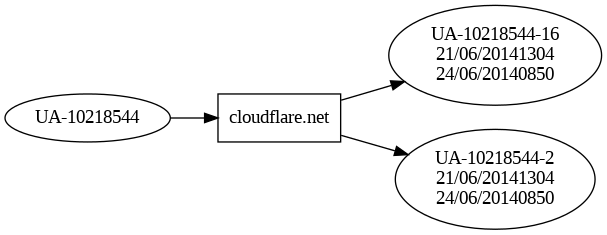

In [2]:
# @markdown #### Enter one or more internet addresses separated by spaces to get their UA/GA codes:
urls = "cloudflare.net" # @param {type:"string"}

# @markdown #### Enter start and end dates:
start_date = "2014-05-29" # @param {type:"date"}
end_date = "2014-06-30" # @param {type:"date"}

# @markdown #### Limits number of snapshots returned. Defaults to -100 (most recent snapshots)
limit = -100 # @param {type:"integer"}

# @markdown #### Can limit snapshots to remove duplicates (1 per hr, day, month, etc.)
frequency = "daily" # @param ["hourly", "daily", "monthly", "yearly"]

from datetime import datetime
import asyncio
import aiohttp
import sys
import os
from IPython.display import Image

# Add the module wayback_google_analytics.utils to the Python load
# path:
cwd = os.getcwd()
if not cwd + '/wga' in sys.path:
    sys.path.insert(0, cwd + '/wga')
print(sys.path)

from wayback_google_analytics.utils import (
    get_limit_from_frequency,
    get_14_digit_timestamp,
    validate_dates,
    COLLAPSE_OPTIONS
)

from wayback_google_analytics.scraper import (
    get_analytics_codes
)

from wayback_google_analytics.output import (
    init_output,
    write_output
)


async def main():
    """Main function. Runs get_analytics_codes() and prints results.

    Args:
        args: Command line arguments (argparse)

    Returns:
        None
    """

    global urls, start_date, end_date, limit, frequency
    print("Entered main", start_date)

    start_date = datetime.fromisoformat(start_date)
    end_date = datetime.fromisoformat(end_date)

    # Check if start_date is before end_date
    if not start_date < end_date:
        raise ValueError("Start date must be before end date.")

    # Update dates to 14-digit format
    if start_date:
        # start_date = get_14_digit_timestamp(start_date)
        start_date = start_date.strftime("%Y%m%d%H%M%S")

    if end_date:
        # end_date = get_14_digit_timestamp(end_date)
        end_date = end_date.strftime("%Y%m%d%H%M%S")

    # Gets appropriate limit for given frequency & converts frequency to collapse option
    if frequency:
        limit = (
            get_limit_from_frequency(
                frequency=frequency,
                start_date=start_date,
                end_date=end_date,
            )
            + 1
        )
        frequency = COLLAPSE_OPTIONS[frequency]

    semaphore = asyncio.Semaphore(10)

    # Warn user if large request
    if abs(int(limit)) > 500 or len(urls) > 9:
        print("limit:", limit)
        response = input(
            f"""Large requests can lead to being rate limited by archive.org.\n\n Current limit: {args.limit} (Recommended < 500) \n\n Current # of urls: {len(urls)} (Recommended < 10, unless limit < 50)

        Do you wish to proceed? (Yes/no)
                         """
        )
        if response.lower() not in ("yes", "y"):
            print("Request cancelled.")
            exit()

    try:
        async with semaphore:
            async with aiohttp.ClientSession() as session:
                results = await get_analytics_codes(
                    session=session,
                    urls=urls,
                    start_date=start_date,
                    end_date=end_date,
                    frequency=frequency,
                    limit=limit,
                    semaphore=semaphore,
                    skip_current=skip_current,
                )
                print(results)

        write_output('output.dot', 'dot', results)
    except aiohttp.ClientError as e:
        print(
            "Your request was rate limited. Wait 5 minutes and try again and consider reducing the limit and # of numbers."
        )


#
# Main
#
urls = urls.split()
skip_current = False

loop = asyncio.get_running_loop()
await loop.create_task(main())

# FIXME: In the original code, each run would create an output file with a
# different name. This made it difficult to display it in the notebook.
# Somehow try to return the name of the output file from the asynchronously
# running main() function.
Image('output.png')
